In [3]:
import random
import math
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [134]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

##### Generate Data

In [16]:

# Generate Data
def GenerateData(select):
    random.seed(100)
    if select == 1:
        CL1 = 7
        CL2 = 7
        data = np.zeros((14,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2+CL1):
            data[i,0] = 3 + random.random()
            data[i,1] = 3 + random.random()
    elif select == 2:
        CL1 = 7
        CL2 = 7
        CL3 = 7
        data = np.zeros((21,2))
        for i in range(0,CL1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1,CL2+CL1):
            data[i,0] = 3 + random.random()
            data[i,1] = 1 + random.random()

        for i in range(CL2+CL1,CL3+CL2+CL1):
            data[i,0] = 1.5 + random.random()
            data[i,1] = 3 + random.random()
    return data

In [33]:
def GenerateData_vectorized(select):
    random.seed(100)
    if select == 1:
        CL1 = 7
        CL2 = 7
        range1 = range(0,CL1)
        range2 = range(CL1,CL1+CL2)
        data = np.zeros((CL1+CL2,2))
        data[range1,0] = 1 + np.random.random(CL1)
        data[range1,1] = 1 + np.random.random(CL1)
        data[range2,0] = 3 + np.random.random(CL2)
        data[range2,1] = 3 + np.random.random(CL2)
    elif select == 2:
        CL1 = 7
        CL2 = 7
        CL3 = 7
        range1 = range(0,CL1)
        range2 = range(CL1,CL1+CL2)
        range3 = range(CL1+CL2,CL1+CL2+CL3)
        data = np.zeros((CL1+CL2+CL3,2))
        data[range1,0] = 1 + np.random.random(CL1)
        data[range1,1] = 1 + np.random.random(CL1)
        data[range2,0] = 3 + np.random.random(CL2)
        data[range2,1] = 1 + np.random.random(CL2)
        data[range3,0] = 1.5 + np.random.random(CL2)
        data[range3,1] = 3 + np.random.random(CL2)
    return data

In [39]:
%%time
data1= GenerateData(2)

CPU times: user 55 µs, sys: 1 µs, total: 56 µs
Wall time: 60.1 µs


In [55]:
%%time
data1= GenerateData_vectorized(2)

CPU times: user 316 µs, sys: 123 µs, total: 439 µs
Wall time: 344 µs


###### Using JIT

In [41]:
import numba
from numba import jit

In [42]:
@jit
def GenerateData_jit(select):
    random.seed(100)
    if select == 1:
        CL1 = 7
        CL2 = 7
        data = np.zeros((14,2))
        for i in range(0,CL1+1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1+1,CL2+CL1):
            data[i,0] = 3 + random.random()
            data[i,1] = 3 + random.random()
    elif select == 2:
        CL1 = 7
        CL2 = 7
        CL3 = 7
        data = np.zeros((21,2))
        for i in range(0,CL1+1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1+1,CL2+CL1+1):
            data[i,0] = 3 + random.random()
            data[i,1] = 1 + random.random()

        for i in range(CL2+CL1+1,CL3+CL2+CL1):
            data[i,0] = 1.5 + random.random()
            data[i,1] = 3 + random.random()
    return data

In [43]:
@jit
def GenerateData_vectorized_jit(select):
    random.seed(100)
    if select == 1:
        CL1 = 7
        CL2 = 7
        range1 = range(0,CL1)
        range2 = range(CL1,CL1+CL2)
        data = np.zeros((CL1+CL2,2))
        data[range1,0] = 1 + np.random.random(CL1)
        data[range1,1] = 1 + np.random.random(CL1)
        data[range2,0] = 3 + np.random.random(CL2)
        data[range2,1] = 3 + np.random.random(CL2)
    elif select == 2:
        CL1 = 7
        CL2 = 7
        CL3 = 7
        range1 = range(0,CL1)
        range2 = range(CL1,CL1+CL2)
        range3 = range(CL1+CL2,CL1+CL2+CL3)
        data = np.zeros((CL1+CL2+CL3,2))
        data[range1,0] = 1 + np.random.random(CL1)
        data[range1,1] = 1 + np.random.random(CL1)
        data[range2,0] = 3 + np.random.random(CL2)
        data[range2,1] = 1 + np.random.random(CL2)
        data[range3,0] = 1.5 + np.random.random(CL2)
        data[range3,1] = 3 + np.random.random(CL2)
    return data

In [48]:
%%time
data_jit = GenerateData_jit(2)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 18.8 µs


In [53]:
%%time
data_vectorized_jit = GenerateData_vectorized_jit(2)

CPU times: user 252 µs, sys: 113 µs, total: 365 µs
Wall time: 274 µs


##### JIT speed-up ratio (Generate Data)

In [60]:
select = 2
report([GenerateData,GenerateData_jit],select)

GenerateData: 1.0
GenerateData_jit: 5.1


In [61]:
select = 2
report([GenerateData_vectorized,GenerateData_vectorized_jit],select)

GenerateData_vectorized: 1.0
GenerateData_vectorized_jit: 1.2


##### Using Cython

In [62]:
%load_ext cython

In [39]:
%%cython -a

import cython
import numpy as np
import random

@cython.boundscheck(False)
@cython.wraparound(False)
def GenerateData_cython(select):
    random.seed(100)
    if select == 1:
        CL1 = 7
        CL2 = 7
        data = np.zeros((14,2))
        for i in range(0,CL1+1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1+1,CL2+CL1):
            data[i,0] = 3 + random.random()
            data[i,1] = 3 + random.random()
    elif select == 2:
        CL1 = 7
        CL2 = 7
        CL3 = 7
        data = np.zeros((21,2))
        for i in range(0,CL1+1):
            data[i,0] = 1 + random.random()
            data[i,1] = 1 + random.random()
        
        for i in range(CL1+1,CL2+CL1+1):
            data[i,0] = 3 + random.random()
            data[i,1] = 1 + random.random()

        for i in range(CL2+CL1+1,CL3+CL2+CL1):
            data[i,0] = 1.5 + random.random()
            data[i,1] = 3 + random.random()
    return data




In [63]:
%%cython -a

import cython
import numpy as np
import random

@cython.boundscheck(False)
@cython.wraparound(False)
def GenerateData_vectorized_cython(select):
    random.seed(100)
    if select == 1:
        CL1 = 7
        CL2 = 7
        range1 = range(0,CL1)
        range2 = range(CL1,CL1+CL2)
        data = np.zeros((CL1+CL2,2))
        data[range1,0] = 1 + np.random.random(CL1)
        data[range1,1] = 1 + np.random.random(CL1)
        data[range2,0] = 3 + np.random.random(CL2)
        data[range2,1] = 3 + np.random.random(CL2)
    elif select == 2:
        CL1 = 7
        CL2 = 7
        CL3 = 7
        range1 = range(0,CL1)
        range2 = range(CL1,CL1+CL2)
        range3 = range(CL1+CL2,CL1+CL2+CL3)
        data = np.zeros((CL1+CL2+CL3,2))
        data[range1,0] = 1 + np.random.random(CL1)
        data[range1,1] = 1 + np.random.random(CL1)
        data[range2,0] = 3 + np.random.random(CL2)
        data[range2,1] = 1 + np.random.random(CL2)
        data[range3,0] = 1.5 + np.random.random(CL2)
        data[range3,1] = 3 + np.random.random(CL2)
    return data




In [43]:
report([GenerateData,GenerateData_cython],select)

GenerateData: 1.0
GenerateData_cython: 1.5


In [66]:
report([GenerateData_vectorized,GenerateData_vectorized_cython],select)

GenerateData_vectorized: 1.0
GenerateData_vectorized_cython: 0.6


##### Calculate Affinity

In [68]:
def CalculateAffinity(data):
    sigma = 1
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity

In [86]:
def eucli_dist(u,v):
    return np.sqrt(np.sum((u-v)**2))

def CalculateAffinity_vectorized(data):
    sigma = 1
    row,col = data.shape
    return np.array([[math.exp(-eucli_dist(data[u,:],data[v,:])/(2*sigma**2)) 
                                                        for u in range(row)] 
                                                        for v in range(row)])
    

In [160]:
report([CalculateAffinity,CalculateAffinity_vectorized],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized: 1.8


In [136]:
def CalculateAffinity_o(data):
    sigma = 1
    col_size = data.shape[0]
    affinity = np.zeros((col_size,col_size))
    for i in range(col_size):
        for j in range(col_size):
            dist = math.sqrt((data[i,0]-data[j,0])**2 + (data[i, 1] - data[j,1])**2)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity

In [137]:
data = GenerateData(2)

np.allclose(CalculateAffinity(data),CalculateAffinity_vectorized(data))

True

##### Using JIT

In [146]:
@jit
def CalculateAffinity_jit(data):
    sigma = 1
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity


In [161]:
report([CalculateAffinity,CalculateAffinity_jit],data)

CalculateAffinity: 1.0
CalculateAffinity_jit: 87.3


In [154]:
@jit
def eucli_vectorized_dist(u,v):
    return np.sqrt(np.sum((u-v)**2))
def CalculateAffinity_vectorized_jit(data):
    sigma = 1
    row,col = data.shape
    return np.array([[math.exp(-eucli_vectorized_dist(data[u,:],data[v,:])/(2*sigma**2)) 
                                                        for u in range(row)] 
                                                        for v in range(row)])

In [162]:
report([CalculateAffinity,CalculateAffinity_vectorized_jit],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized_jit: 1.7


In [178]:
report([CalculateAffinity_vectorized,CalculateAffinity_vectorized_jit],data)

CalculateAffinity_vectorized: 1.0
CalculateAffinity_vectorized_jit: 0.3


In [184]:
report([CalculateAffinity_vectorized_jit,CalculateAffinity_jit],data)

CalculateAffinity_vectorized_jit: 1.0
CalculateAffinity_jit: 211.6


##### Using Cython

In [165]:
%%cython -a

import cython
import numpy as np
import random
import math

@cython.boundscheck(False)
@cython.wraparound(False)
def CalculateAffinity_cython(data):
    sigma = 1
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity

In [166]:
report([CalculateAffinity,CalculateAffinity_cython],data)

CalculateAffinity: 1.0
CalculateAffinity_cython: 1.2


In [167]:
%%cython -a

import cython
import numpy as np
import random
import math

@cython.boundscheck(False)
@cython.wraparound(False)
def eucli_vectorized_dist(u,v):
    return np.sqrt(np.sum((u-v)**2))
def CalculateAffinity_vectorized_cython(data):
    sigma = 1
    row,col = data.shape
    return np.array([[math.exp(-eucli_vectorized_dist(data[u,:],data[v,:])/(2*sigma**2)) 
                                                        for u in range(row)] 
                                                        for v in range(row)])


In [173]:
report([CalculateAffinity,CalculateAffinity_vectorized_cython],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized_cython: 0.6


In [203]:
#  generate the data, calculate the affinity 
data = GenerateData(2)
affinity = CalculateAffinity(data)
k = 3
def Spectral(k):
  
    # compute the degree matrix
    D =  np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
        D[i,i] = sum(affinity[i,:])


    #compute the normalized laplacian / affinity matrix (method 1)
    NL1 = np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
         for j in range(affinity.shape[1]):
                NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i]*math.sqrt(D[j,j])))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    new_eigvec = eigvector[:,sort_index[-k:][::-1]]

    
    #new_eigvec = eigvector[:,(eigvector.shape[0]-(k-1)):(eigvector.shape[0]+1)]
    #construct the normalized matrix U from the obtained eigen vectors
    U = np.zeros((new_eigvec.shape))
    for i in range(new_eigvec.shape[0]):
        n = math.sqrt(sum(new_eigvec[i,:]**2));   
        U[i,:] = new_eigvec[i,:]/n 
    return U

In [204]:
@jit
#  generate the data, calculate the affinity 
def Spectral_jit(k):
  
    # compute the degree matrix
    D =  np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
        D[i,i] = sum(affinity[i,:])


    #compute the normalized laplacian / affinity matrix (method 1)
    NL1 = np.zeros((affinity.shape))
    for i in range(affinity.shape[0]):
         for j in range(affinity.shape[1]):
                NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i]*math.sqrt(D[j,j])))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    new_eigvec = eigvector[:,sort_index[-k:][::-1]]

    
    #new_eigvec = eigvector[:,(eigvector.shape[0]-(k-1)):(eigvector.shape[0]+1)]
    #construct the normalized matrix U from the obtained eigen vectors
    U = np.zeros((new_eigvec.shape))
    for i in range(new_eigvec.shape[0]):
        n = math.sqrt(sum(new_eigvec[i,:]**2));   
        U[i,:] = new_eigvec[i,:]/n 
    return U

In [207]:
report([Spectral,Spectral_jit],k)

Spectral: 1.0
Spectral_jit: 1.5


In [191]:
data = GenerateData(2)
affinity = CalculateAffinity(data)

# compute the degree matrix
D =  np.zeros((affinity.shape))
for i in range(affinity.shape[0]):
    D[i,i] = sum(affinity[i,:])


#compute the normalized laplacian / affinity matrix (method 1)
NL1 = np.zeros((affinity.shape))
for i in range(affinity.shape[0]):
    for j in range(affinity.shape[1]):
        NL1[i,j] = affinity[i,j]/(math.sqrt(D[i,i]*math.sqrt(D[j,j])))
k = 3
eigvalue,eigvector = la.eig(NL1)
sort_index = np.argsort(eigvalue)
new_eigvec = eigvector[:,sort_index[-k:][::-1]]

#construct the normalized matrix U from the obtained eigen vectors
U = np.zeros((new_eigvec.shape))
for i in range(new_eigvec.shape[0]):
    n = math.sqrt(sum(new_eigvec[i,:]**2));   
    U[i,:] = new_eigvec[i,:]/n
 

When n_clusters = 3 , we have the silhouette_score = 0.86439009484


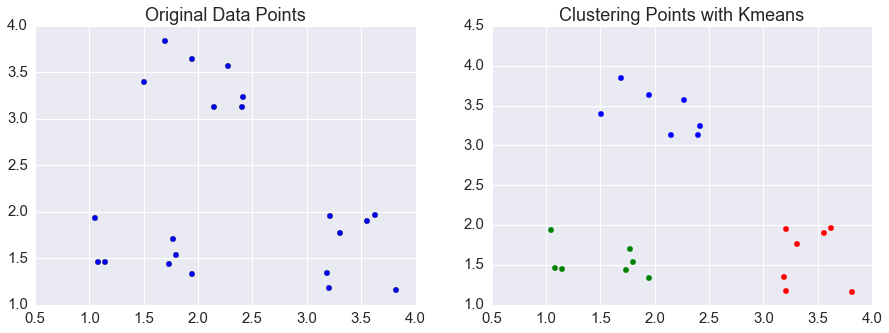

In [196]:
# First method: Kmeans

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# select the four predicators in iris, create the unsupervised form
X=Spectral(k,data,affinity)

# generate the possible range 
clusters =range(2,8)

all_score = []
#for item in clusters:

    # Initialize the clusterer with n_clusters value in clusters
clusterer = KMeans(n_clusters=k, random_state=42)
cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
silhouette_avg = silhouette_score(X, cluster_labels)


# Find the max silhouette score
#Num_cluster = [i+2 for i, j in enumerate(all_score) if j == max(all_score)]

   
print("When n_clusters =", k,
          ", we have the silhouette_score =", silhouette_avg)

#answer=str(Num_cluster).strip('[]')

# Make a pairwise scatter plot
clust_result = KMeans(n_clusters=k, random_state=10)
cluster_labels = clust_result.fit_predict(X)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points with Kmeans')
plt.show()


